In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import math

In [ ]:
df = pd.read_csv('data.csv')
df['Date/Time'] = pd.to_datetime(df['Date/Time'])

df = df.fillna(0)

df['Total Precip (in)'] = df['Total Precip (in)'].fillna(0)
df['Has_Precip'] = (df['Total Precip (in)'] > 0).astype(int)

df['Hour'] = df['Date/Time'].dt.hour
df['Month'] = df['Date/Time'].dt.month
df['Day_of_Year'] = df['Date/Time'].dt.dayofyear
df['Day_of_Week'] = df['Date/Time'].dt.dayofweek


wind_dir_median = df['Wind Direction (°)'].median()
df['Wind Direction (°)'] = df['Wind Direction (°)'].fillna(wind_dir_median)
    
df['Wind_Sin'] = np.sin(np.radians(df['Wind Direction (°)']))
df['Wind_Cos'] = np.cos(np.radians(df['Wind Direction (°)']))

trend_map = {'F': -1, 'S': 0, 'R': 1}
df['Pressure_Trend_Num'] = df['Pressure Trend Code'].map(trend_map).fillna(0)

df.columns

Index(['Date/Time', 'Temperature (°F)', 'Dew Point (°F)', 'Heat Index (°F)',
       'Feels Like (°F)', 'Wind Chill (°F)', 'Wind Speed (mph)',
       'Wind Gust (mph)', 'Wind Direction (°)', 'Wind Direction',
       'Humidity (%)', 'Total Precip (in)', 'Hourly Precip (in)',
       'Hourly Snow (in)', 'Visibility (mi)', 'Pressure (inHg)',
       'Pressure Trend Code', 'Pressure Trend', 'UV Index', 'UV Description',
       'Weather Summary', 'Cloud Cover', 'Has_Precip', 'Hour', 'Month',
       'Day_of_Year', 'Day_of_Week', 'Wind_Sin', 'Wind_Cos',
       'Pressure_Trend_Num'],
      dtype='object')

In [171]:
input_features = ['Wind Speed (mph)', 'Pressure Trend Code', 'Humidity (%)', 'UV Index',"Pressure (inHg)", 'Hour',]
output_feature = ["Has_Precip"]

has_precip = df[df['Has_Precip'] == 1]
no_precip = df[df['Has_Precip'] == 0]

has_precip_sample = has_precip.sample(n=500, random_state=42)
no_precip_sample = no_precip.sample(n=500, random_state=42)

balanced_df = pd.concat([has_precip_sample, no_precip_sample]).sample(frac=1, random_state=42).reset_index(drop=True)

input_features_df = balanced_df[input_features]
output_feature_df = balanced_df[output_feature]


In [ ]:
# Calculate correlation of numerical columns with Has_Precip
numerical_columns = balanced_df.select_dtypes(include=['number']).columns
correlation_results = balanced_df[numerical_columns].corr()['Has_Precip'].sort_values(ascending=False)
print("Correlation of numerical columns with Has_Precip:")
print(correlation_results)

Correlation of numerical columns with Has_Precip:
Has_Precip             1.000000
Pressure Trend Code    0.541753
Total Precip (in)      0.454695
Humidity (%)           0.248716
Wind Speed (mph)       0.110008
Wind_Cos               0.098381
Wind Direction (°)     0.071857
Wind Gust (mph)        0.069282
Dew Point (°F)         0.056886
Hourly Precip (in)     0.042687
Day_of_Week           -0.011050
Day_of_Year           -0.034644
Month                 -0.035064
Visibility (mi)       -0.057488
Temperature (°F)      -0.060874
Wind Chill (°F)       -0.062510
Heat Index (°F)       -0.062816
Feels Like (°F)       -0.064140
Wind_Sin              -0.096789
Hour                  -0.110164
UV Index              -0.215827
Pressure (inHg)       -0.234894
Hourly Snow (in)            NaN
Pressure_Trend_Num          NaN
Name: Has_Precip, dtype: float64


In [ ]:
input_features_matrix = input_features_df.to_numpy()

output_feature_vector = output_feature_df.to_numpy().flatten()

[[ 6.    2.   71.    0.   29.9   8.  ]
 [ 8.    0.   77.    0.   30.29 12.  ]
 [ 9.    0.   53.    0.   30.59  9.  ]
 ...
 [16.    2.   68.    1.   30.17 20.  ]
 [ 6.    1.   54.    0.   30.11 11.  ]
 [16.    1.   90.    0.   30.17 11.  ]]
[0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 1 0 1 1 1 0 0 0 1 1 0 1 1 1 0
 0 0 1 1 1 1 0 1 1 0 0 1 0 0 0 1 0 1 1 0 1 1 0 1 1 0 1 0 0 0 0 1 0 1 1 0 0
 1 1 0 1 0 1 0 1 1 1 1 0 0 0 0 1 1 1 0 1 0 1 0 1 1 0 0 1 0 1 0 0 0 0 1 0 0
 0 0 0 1 1 1 0 0 1 0 1 0 1 1 0 0 1 0 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 0 0 0 1
 0 1 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 0 0
 1 1 1 0 0 0 0 0 1 1 1 1 1 0 1 1 0 0 0 0 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0
 0 1 0 1 0 1 0 0 1 0 1 0 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 0 1 1 0 0 0
 1 0 1 1 1 1 0 0 1 0 1 1 1 0 1 0 1 1 0 1 0 0 0 1 1 1 0 1 1 1 0 0 0 0 1 1 1
 0 1 1 1 0 1 1 1 0 0 1 0 0 0 0 0 0 0 1 1 1 1 0 1 1 1 1 0 0 0 1 1 0 1 0 1 0
 0 1 1 0 0 0 0 1 1 1 1 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0
 1 0 1 1 1

In [174]:
scaler = MinMaxScaler()
X_scale = scaler.fit_transform(input_features_matrix)
X_scale = np.hstack((X_scale, np.ones((X_scale.shape[0], 1))))
X_scale

array([[0.15789474, 1.        , 0.6547619 , ..., 0.55769231, 0.34782609,
        1.        ],
       [0.21052632, 0.        , 0.72619048, ..., 0.80769231, 0.52173913,
        1.        ],
       [0.23684211, 0.        , 0.44047619, ..., 1.        , 0.39130435,
        1.        ],
       ...,
       [0.42105263, 1.        , 0.61904762, ..., 0.73076923, 0.86956522,
        1.        ],
       [0.15789474, 0.5       , 0.45238095, ..., 0.69230769, 0.47826087,
        1.        ],
       [0.42105263, 0.5       , 0.88095238, ..., 0.73076923, 0.47826087,
        1.        ]])

In [175]:
phi = X_scale
y = output_feature_vector

In [176]:
Phi_train, Phi_test, y_train, y_test = train_test_split(phi, y, test_size=0.2)

In [207]:
eta = 0.01

W1 = np.random.randn(len(input_features) + 1,4)
W2 = np.random.randn(4,1)
Phi_train.shape

(800, 7)

In [208]:
def f(x):
    h = np.maximum(0, W1.T.dot(x))
    return 1/ (1 + math.e**(-1*(W2.T.dot(h))))

# descent
errors = []
epochs = 1500
n = Phi_train.shape[0]
for epoch in range(epochs):
    dW2 = 0
    # first weight and derivative 
    for i, j in enumerate(y_train):
        #reshape first set
        x = np.reshape(Phi_train[i], (len(input_features) + 1,1))
        f_x = f(x)
        h = np.maximum(0, W1.T.dot(x))
        dW2 += (1/n) * (f_x - y_train[i])*h

    W2 = W2 - eta * dW2

    #W1 derivative
    dW1 = 0
    for i, j in enumerate(y_train):
        x = np.reshape(Phi_train[i], (len(input_features) + 1,1))
        relu_derivative = (W1.T.dot(x) > 0).astype(float)  # Derivative of ReLU
        gradient = (f_x - y_train[i]) * W2 * relu_derivative
    
        
        # Update accumulated gradient
        dW1 += (1/n) * np.outer(x,(gradient.T))

    # After loop, update W1
    W1 = W1 - eta * dW1
    e = (1/n) * np.sum(np.square(f(Phi_train.T) - y_train))
    errors.append(e)

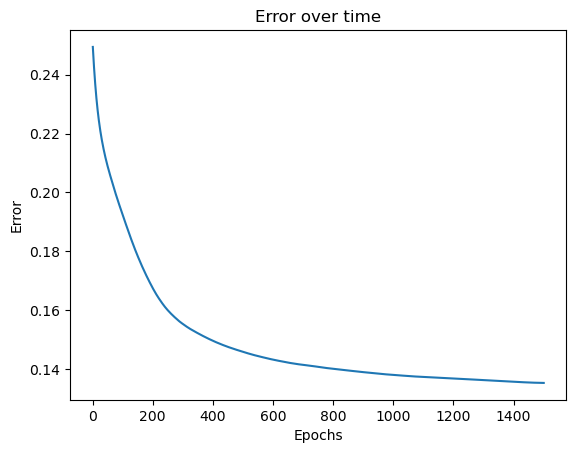

In [209]:
plt.plot(range(1, epochs + 1), errors, label='line')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Error over time')
plt.show()

In [210]:
accuracy = np.mean(np.round(f(Phi_test.T)) == y_test)
print(f"Accuracy: {accuracy * 100}%")
print(np.sum(np.round(f(Phi_test.T)) == 1))


Accuracy: 83.0%
102
